# SESSION_3

Prerequisites: In a terminal, You need to create, install biopython and activate the `Conda` env as follow before to start jupyter

**We will create a new env called curso_3**

!conda create --name curso_3

!conda install -y -n curso_3 -c bioconda gepard miniasm minimap2 flye raven-assembler jupyter pandas wget shasta canu

!conda activate curso_3

!jupyter notebook &

# Genome assemblies 

In this part we will assemble a B. subtilis genome using different tools:  
    `Miniasm`,  
    `Flye`,  
    `Raven`,  
    `Canu`,  
    `Shasta`,... into others

# Genome assembly with Minimap2 and Miniasm

In [ ]:
!minimap2

In [ ]:
!miniasm

The `minimap2-miniasm` pipeline is an very fast and memory efficient way of assembling Long-Read data. However, it has several characteristics that differ from other assemblers:

`Miniasm` outputs unitigs not contigs.  
Unitigs are unique parts in the `assembly grap`. This means all reads in your data “agree” on this part of the assembly. One could say they are high-confidence contigs. In contrast, contigs may include regions with ambiguous read information, depending on the algorithm used. As a result unitigs can be shorter and the miniasm assemblies more fragmented.
**`Miniasm` does not build a consensus sequence of the assembly. Thus, the error rate of the resulting unitigs is approximately the same as the error rate of the raw reads`Miniasm` does not build a consensus sequence of the assembly. Thus, the error rate of the resulting unitigs is approximately the same as the error rate of the raw reads.**  

(see https://timkahlke.github.io/LongRead_tutorials/ASS_M.html).    
(see https://doi.org/10.1093/bioinformatics/btw152).

Lets find all overlaps between reads from initial Bacillus subtilis dataset using minimap2. Minimap2 does this in the similar way it maps reads to the reference. It concatenates reads from the dataset in a single sequence, it indexes the concatenated sequence, and then it maps every read to that concatenated sequence.

In [ ]:
!minimap2 \
    -t 4 \
    -x ava-ont \
    -o data/bacillus_subtilis/bs_reads_to_reads.paf \
    data/bacillus_subtilis/bs_reads.fastq.gz \
    data/bacillus_subtilis/bs_reads.fastq.gz

In [ ]:
import pandas
paf = pandas.read_csv('data/bacillus_subtilis/bs_reads_to_reads.paf', header = None, delimiter = '\t')
paf.drop_duplicates(subset = 0, keep = 'first', inplace = True)
paf

In [ ]:
!miniasm -f data/bacillus_subtilis/bs_reads.fastq.gz \
 data/bacillus_subtilis/bs_reads_to_reads.paf > bs_assembly_miniasm.gfa

The results of the assembly if in the [`GFA` format](https://github.com/GFA-spec/GFA-spec)

In [ ]:
!head -n 1 bs_assembly_miniasm.gfa

In [ ]:
!tail -n 10 bs_assembly_miniasm.gfa

We can see that miniasm was able to produce only one unitig (path of the assembly graph without external edges) which has similar length to the reference genome.  
We can draw the assembly graph in Bandage, which can be run both in command line and as a GUI. We will see that the graph lacks circularisation as miniasm does not support this. (https://towardsdatascience.com/visualising-assembly-graphs-fb631f46bbd1)

 [`Bandage`](http://rrwick.github.io/Bandage/)

In [ ]:
!wget https://github.com/rrwick/Bandage/releases/download/v0.8.1/Bandage_Ubuntu_dynamic_v0_8_1.zip

In [ ]:
!unzip Bandage_Ubuntu_dynamic_v0_8_1.zip

In [ ]:
!Bandage_Ubuntu_dynamic_v0_8_1/Bandage

In order to validate the sequence we got from `miniasm`, we can align it to the reference and visualize the alignment with Gepard.   
Extracting unitigs from the GFA format can be done with the l$following command.

In [ ]:
!awk '/^S/{print ">"$2"\n"$3}' bs_assembly_miniasm.gfa > bs_assembly_miniasm.fasta

In [ ]:
!gepard

Align data/bacillus_subtilis/bs_ref.fasta with bs_assembly_miniasm.fasta

Save the image as bs_assembly_miniasm_gepard_vs_ref.png

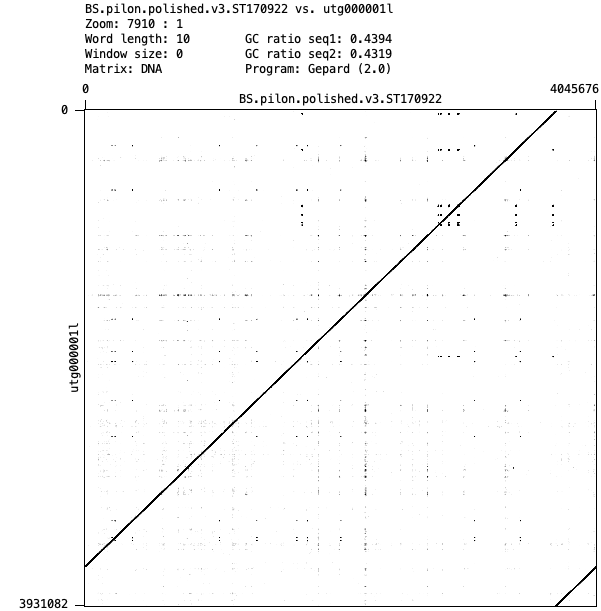

In [1]:
from IPython.display import Image
Image("bs_assembly_miniasm_gepard_vs_ref.png")

`Miniasm` is a great long-read assembly tool: straight-forward, effective and very fast.  
**However, it does not include a polishing step (Polishing: workflow in which assembly software searches for local misassemblies and other inconsistencies in a draft genome assembly and then corrects them), so its assemblies have a high error rate – they are essentially made of stitched-together pieces of long reads.**. 
[`Minipolish`](https://github.com/rrwick/Minipolish) can be used to polish GFA graph produced by `Miniasm`.

# GENOME ASSEMBLY WITH `FLYE`

`Flye` is a de novo assembler for single-molecule sequencing reads, such as those produced by PacBio and Oxford Nanopore Technologies. It is designed for a wide range of datasets, from small bacterial projects to large mammalian-scale assemblies. The package represents a complete pipeline: it takes raw PacBio / ONT reads as input and outputs polished contigs. Flye also has a special mode for metagenome assembly.

Currently, `Flye` will produce collapsed assemblies of diploid genomes, represented by a single mosaic haplotype. To recover two phased haplotypes consider applying HapDup after the assembly.  

(see https://github.com/fenderglass/Flye).  
(see doi:10.1038/s41587-019-0072-8).  

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('DKSuYPFHAWU', 560, 315) 

In [ ]:
from IPython.display import Image
Image(url = "https://media.springernature.com/m312/springer-static/image/art%3A10.1038%2Fs41587-019-0072-8/MediaObjects/41587_2019_72_Fig1_HTML.png?as=webp")

In [ ]:
!flye

In [ ]:
!flye --nano-raw data/bacillus_subtilis/bs_reads.fastq.gz --genome-size 4000000 --out-dir FLYE

In [ ]:
!ls

Open the assembly of flye with Bandage

# GENOME ASSEMBLY WITH `RAVEN`

[`Raven`](https://github.com/lbcb-sci/raven) is a de novo genome assembler for long uncorrected reads. It implements the assembly graph and the corresponding simplification methods (except for short overlap removal).


In [ ]:
!raven

`Raven` is a complete OLC assembler which takes as input only a set of third generation sequences. For this demo it omits the consensus phase (number of polishing rounds set to 0 as default) and has an additional parameter called `--step` which enables different level of preprocessing/postprocessing functions. It will additionally output the state of the assembly graph after each modification. The state of the graph at the end of the layout phase will be stored in `<dataset_name>_final.gfa` while the untigis will be printed to stdout. Lets run it without pre/post processing.

In [ ]:
!raven -t 4 -p 0 data/bacillus_subtilis/bs_reads.fastq.gz --graphical-fragment-assembly bs_assembly_raven.gfa > bs_assembly_raven.fasta

In [ ]:
!ls

In [ ]:
!tail -n 10 bs_assembly_raven.gfa

The assembly can be checked with `Bandage`.

Running raven with chimeric resolution helps in reconstructing the whole bacterial genome in one circular contig.

In [ ]:
!raven -t 4 -p 2 data/bacillus_subtilis/bs_reads.fastq.gz --graphical-fragment-assembly bs_assembly_raven-p2.gfa> bs_assembly_raven_final-p2.fasta

In [ ]:
!gepard

# OTHERS TOOLS 

`CANU`

`Canu` is a fork of the Celera Assembler, designed for high-noise single-molecule sequencing (such as the PacBio RS II/Sequel or Oxford Nanopore MinION).

Canu is a hierarchical assembly pipeline which runs in four steps:

Detect overlaps in high-noise sequences using MHAP
Generate corrected sequence consensus
Trim corrected sequences
Assemble trimmed corrected sequences  

(see https://github.com/marbl/canu).  
(see http://canu.readthedocs.org/en/latest/)

**Canu is very slow, so don't run it during the course**

In [ ]:
from IPython.display import Image
Image(url = "https://genome.cshlp.org/content/27/5/722/F1.large.jpg")

In [ ]:
!canu

**step 1 correction of nanopore reads**
The correction stage selects the best overlaps to use for correction, estimates corrected read lengths, and generates corrected reads

In [ ]:
!canu -correct -p bs_assembly_canu genomeSize=4M  -nanopore data/bacillus_subtilis/bs_reads.fastq.gz

**step 2 trimming & assemble**
The trimming stage identifies unsupported regions in the input and trims or splits reads to their longest supported range. The assembly stage makes a final pass to identify sequencing errors; constructs the best overlap graph; and outputs contigs, an assembly graph, and summary statistic

In [ ]:
!canu -trim-assemble -p bs_assembly_canu genomeSize=4M -nanopore-corrected bs_assembly_canu.correctedReads.fasta.gz

# OTHERS TOOLS

`SHASTA`
https://github.com/chanzuckerberg/shasta
The goal of Shasta is to rapidly produce accurate assembled sequence using as input DNA reads generated by Oxford Nanopore flow cells.
Computational methods used by the `Shasta` assembler include:
Using a run-length representation of the read sequence. This makes the assembly process more resilient to errors in homopolymer repeat counts, which are the most common type of errors in Oxford Nanopore reads.
Using in some phases of the computation a representation of the read sequence based on markers, a fixed subset of short k-mers (k ≈ 10).

In [ ]:
!shasta

**For more information about performance of de novo assembler please see**:  https://www.frontiersin.org/articles/10.3389/fcimb.2021.696669/full 

In [ ]:
from IPython.display import Image
Image("https://www.frontiersin.org/files/Articles/696669/fcimb-11-696669-HTML-r1/image_m/fcimb-11-696669-g001.jpg")


In [ ]:
from IPython.display import Image
Image("https://www.frontiersin.org/files/Articles/696669/fcimb-11-696669-HTML-r1/image_m/fcimb-11-696669-t002.jpg")

In [ ]:
from IPython.display import Image
Image("https://www.frontiersin.org/files/Articles/696669/fcimb-11-696669-HTML-r1/image_m/fcimb-11-696669-g002.jpg")

In [ ]:
from IPython.display import Image
Image("https://www.frontiersin.org/files/Articles/696669/fcimb-11-696669-HTML-r1/image_m/fcimb-11-696669-g003.jpg")